In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU

os.environ['CUDA_VISIBLE_DEVICES']="2"

In [4]:
train_x_df=pd.read_csv('train_x_df.csv')
train_y_df=pd.read_csv('train_y_df.csv')
test_x_df=pd.read_csv('test_x_df.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [5]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [6]:
train_y_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844


In [7]:
print(train_x_df.sample_id.nunique())

7362


In [8]:
train_x = tf.reshape(train_x_df.iloc[:,3].values, [-1, 1380, 1])
train_y = tf.reshape(train_y_df.iloc[:,3].values, [-1, 120, 1])
test_x = tf.reshape(test_x_df.iloc[:,3].values, [-1, 1380, 1])

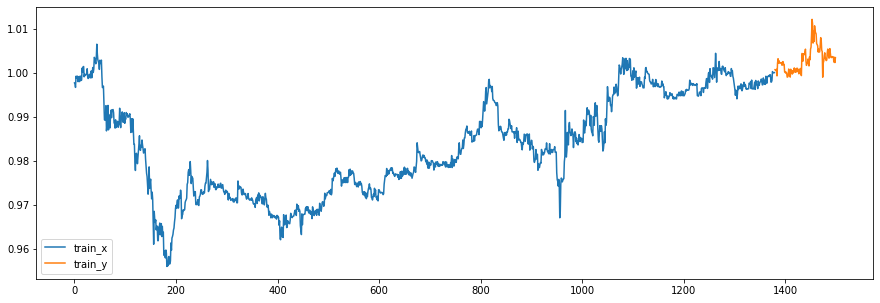

In [9]:

plt.figure(figsize=(15,5))


plt.plot(train_x[2,:,0], label='train_x')
plt.plot(np.arange(train_x.shape[1],train_x.shape[1]+ train_y.shape[1]), train_y[2, :, 0], label='train_y')
plt.legend()

In [10]:
input_window=170
output_window=60
window=input_window + output_window

train_window_x= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, input_window, 1))
train_window_y= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//230, output_window, 1))
print(train_window_x.shape, train_window_y.shape)

for example in range(train_x.shape[0]):
    
    for start in range(0,  train_x.shape[1]-(input_window + output_window), 230):
        end=start+input_window
        train_window_x[example, start//230, :, :] = train_x[example, start: end               , :]
        train_window_y[example, start//230, :, :] = train_x[example, end  : end+ output_window, :]

(7362, 5, 170, 1) (7362, 5, 60, 1)


In [11]:
new_train_x=tf.reshape(train_window_x, [-1, 170, 1])
new_train_y=tf.reshape(train_window_y, [-1, 60, 1])

In [13]:
time        = new_train_x.shape[1] #170
num_features= new_train_x.shape[2] #1
OUT_STEPS   = new_train_y.shape[1] #60

#####층 쌓기###########


model=Sequential([
  LSTM(64, input_shape=(time, num_features), dropout=0.2, recurrent_dropout=0.2, ),
  Dense(64),
  Dense(OUT_STEPS * num_features), 
  Reshape([OUT_STEPS, num_features])
])



#######Compile 구성하기################


model.compile(optimizer='adam', loss='mae', metrics=['mae'])
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)


######################
history = model.fit(new_train_x, new_train_y, epochs=30, batch_size=128, validation_split = 0.2, verbose=0, callbacks=[PrintDot(), early_stop, save_best_only , reduceLR])

KeyboardInterrupt: ignored

In [14]:
print(new_train_x.shape, new_train_y.shape)

(36810, 170, 1) (36810, 60, 1)


In [15]:
submission=np.zeros((529, 120, 9))
auto_x=test_x
auto_x.shape

TensorShape([529, 1380, 1])

In [16]:
end_=120
output_window = 60

for i in range(end_//output_window):
    start_ = i *output_window
    next_ = model.predict(auto_x[:, -170:, :])
    auto_x=tf.concat([auto_x, next_], axis=1)
    print(auto_x.shape)
    submission[:, start_ : start_ + output_window, :] = next_

(529, 1440, 1)
(529, 1500, 1)


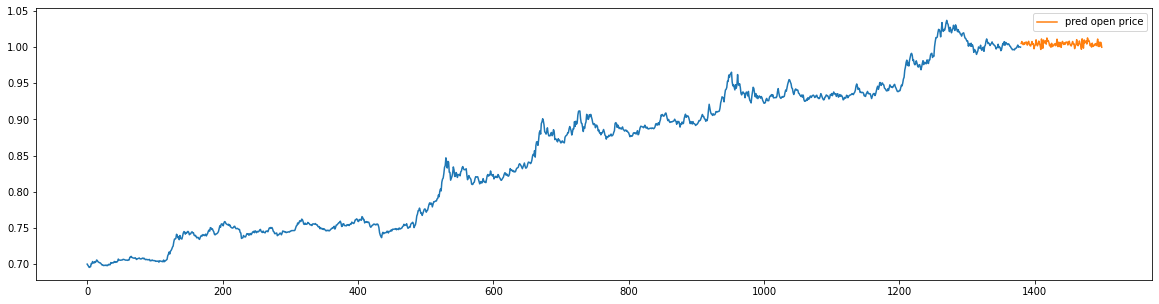

In [17]:

plt.figure(figsize=(20,5))

plt.plot(test_x[2,:, 0])
plt.plot(np.arange(test_x.shape[1], test_x.shape[1]+ submission.shape[1]), submission[2, :, 0], label='pred'')
plt.legend()
